## Deep Learning in Healthcare - Project

### Imports

In [ ]:
!python -c "import torch; print(torch.__version__)"

1.13.1+cu116


In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchio 

In [ ]:
import torch
import os
import typing
import torch_geometric

import numpy as np
import typing

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import time

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch_geometric.datasets as datasets
import torch_geometric.utils as U
from torch_geometric.loader import DataLoader

from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv

from sklearn.utils import shuffle

import torchio

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Setup Cuda device for GPU acceleration


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Loading the datasets

We load the three brain extraction datasets and combine them to an equally distributed dataset containing samples from all of them. They will later be randomly shuffled.

In [ ]:
# Guy's Hospital dataset (Philips 1.5T)
X_guys = np.load("/content/drive/MyDrive/DLH_Assignment/brain_extraction/X_Guys.npy")
y_guys = np.load("/content/drive/MyDrive/DLH_Assignment/brain_extraction/y_Guys.npy")

# Institute of Psychatry Hospital dataset (GE 1.5T)
X_iop = np.load("/content/drive/MyDrive/DLH_Assignment/brain_extraction/X_IOP.npy")
y_iop = np.load("/content/drive/MyDrive/DLH_Assignment/brain_extraction/y_IOP.npy")

# Hammersmith Hospital dataset (Philips 3T)
X_hh = np.load("/content/drive/MyDrive/DLH_Assignment/brain_extraction/X_HH.npy")
y_hh = np.load("/content/drive/MyDrive/DLH_Assignment/brain_extraction/y_HH.npy")

# Combine dataset, eq
X_total = np.concatenate((X_guys[71:142], X_iop, X_hh[71:142]))
y_total = np.concatenate((y_guys[71:142], y_iop, y_hh[71:142]))

X_total, y_total = shuffle(X_total, y_total)

#### Visualizing Samples 
We visualize some examples to get a feeling for the availalble data.

Guy's Hospital Set Size: 317
IOP Set Size: 71
Hammersmith Hospital Set Size: 176


<Figure size 640x480 with 0 Axes>

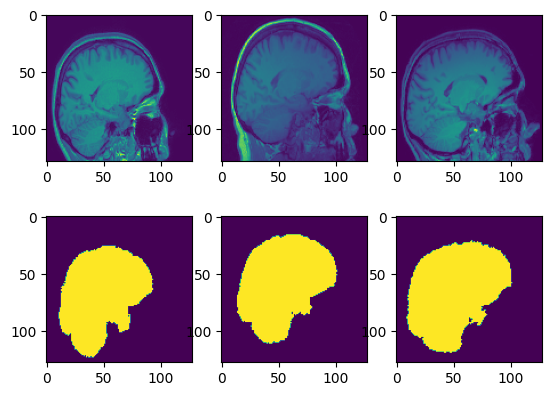

In [ ]:
# How much data is available in each dataset
print("Guy's Hospital Set Size:", len(X_guys))
print("IOP Set Size:", len(X_iop))
print("Hammersmith Hospital Set Size:", len(X_hh))


# Visualize examples
plt.figure()

f, axarr = plt.subplots(2,3) 
axarr[0,0].imshow(np.rot90(X_guys[0][10]))
axarr[1,0].imshow(np.rot90(y_guys[0][10]))

axarr[0,1].imshow(np.rot90(X_iop[0][10]))
axarr[1,1].imshow(np.rot90(y_iop[0][10]))

axarr[0,2].imshow(np.rot90(X_hh[0][10]))
axarr[1,2].imshow(np.rot90(y_hh[0][10]))



### Preparing the data

#### Centring (Standardizing the data)

We standardize the data to have a zero mean and unit variance.

In [ ]:
def centring(X):
    epsilon = 1e-7 # To prevent division by 0
    a = (X - X.mean(axis=0)) / (X.std(axis=0) + epsilon)
    return a

In [ ]:
X_total_c = centring(X_total)

(213, 40, 128, 128)


We visualize the centered data to sanity check the results.

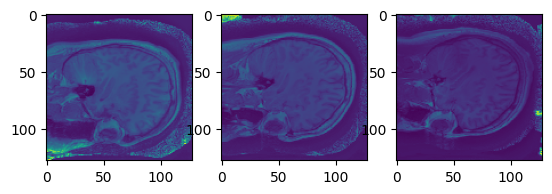

In [ ]:
f, axarr = plt.subplots(1,3) 

axarr[0].imshow(X_total_c[40][0])
axarr[1].imshow(X_total_c[71][0])
axarr[2].imshow(X_total_c[145][0])

#### Adding Channels

We explicitly add the channel dimension for later processing with NumPy and PyTorch.

In [ ]:
def add_channels(x):
  return np.reshape(x,[x.shape[0],1,x.shape[1],x.shape[2],x.shape[3]])

In [ ]:
X_total_c = add_channels(X_total_c)

#### One-hot-encoding of labels

We transform the labels into one-hot-encoded vectors as a ground truth for later classification.

In [ ]:
def to_one_hot(y, num_classes):
    vecs = [([1 if j == i else 0 for j in range(num_classes)]) for i in range(num_classes)]
    one_hot = np.array([[[[vecs[int(e)] for e in r] for r in l] for l in i] for i in y])
    return one_hot

In [ ]:
y_total = to_one_hot(y_total, 2)

In [ ]:
y_total = np.moveaxis(y_total,4 ,1)
print(y_total.shape)

(213, 2, 40, 128, 128)


#### Numpy PyTorch-Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class numpy_dataset(Dataset): 
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.target = torch.tensor(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

We extend the classical Dataset class with on-the-fly domain specific augmentations, which do not change the segmentation labels.

In [ ]:
class augmented_numpy_dataset(Dataset):
    def __init__(self, data, target, transform=True):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            transforms = {'ghost': augmented_numpy_dataset._ghost(x), 
                          'noise': augmented_numpy_dataset._noise(x), 
                          'spike': augmented_numpy_dataset._spike(x),
                          'motion': augmented_numpy_dataset._motion(x),
                          'none': augmented_numpy_dataset._none(x)}
            k = list(transforms.keys())
            n = torch.randperm(5)[0]
            x = transforms[k[n]]
        return x, y

    def __len__(self):
        return len(self.data)

    @staticmethod
    def _ghost(X):
        transform = torchio.RandomGhosting()
        X = transform(X)
        return X
    @staticmethod
    def _noise(X):
        transform = torchio.RandomNoise(std = 0.1)
        return X
    @staticmethod
    def _spike(X):
        transfrom = torchio.RandomSpike(intensity = 4)
        return X
    @staticmethod
    def _motion(X):
        transfrom = torchio.RandomMotion()
        return X
    @staticmethod
    def _none(X):
        return X

## Models


### Baseline Model - 3D-UNet

For the models with less layers used in the study, simply symmetricly remove the last (first) encoder (decoder) layers.

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, init_features=8, out_channels=2):
        super(UNet, self).__init__()

        features = init_features

        # Down Conv
        self.encoder1 = UNet._block(in_channels, features)
        self.encoder2 = UNet._block(features, 2 * features)
        self.pool1 = nn.MaxPool3d(2, stride=2)
        self.encoder4 = UNet._block(2 * features, 4 * features)
        self.pool2 = nn.MaxPool3d(2, stride=2)
        self.encoder6 = UNet._block(4 * features, 8 * features)
        self.pool3 = nn.MaxPool3d(2, stride=2)
        self.encoder8 = UNet._block(8 * features, 16 * features)

        # Up Conv
        self.upconv1 = nn.Upsample(scale_factor=2, mode='trilinear')
        self.decoder1 = UNet._block(16 * features + 8 * features, 8 * features)
        self.upconv2 = nn.Upsample(scale_factor=2, mode='trilinear')
        self.decoder3 = UNet._block(8 * features + 4 * features, 4 * features)
        self.upconv3 = nn.Upsample(scale_factor=2, mode='trilinear')
        self.decoder5 = UNet._block(4 * features + 2 * features, 2 * features)

        # Classification
        self.decoder6 = nn.Conv3d(2* features, out_channels, 3 , padding = 1)
        self.act = nn.Softmax(dim = 1)

    def forward(self, x):

        # Down Conv
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.pool1(enc2)
        enc5 = self.encoder4(enc3)
        enc6 = self.pool2(enc5)
        enc8 = self.encoder6(enc6)
        enc9 = self.pool3(enc8)
        enc11 = self.encoder8(enc9)

        # Up Conv
        dec1 = torch.cat((enc8, self.upconv1(enc11)), dim = 1)
        dec2 = self.decoder1(dec1)
        dec4 = torch.cat((enc5,self.upconv2(dec2)), dim = 1)
        dec5 = self.decoder3(dec4)
        dec7 = torch.cat((enc2,self.upconv2(dec5)), dim = 1)
        dec8 = self.decoder5(dec7)

        # Classification
        dec9 = self.decoder6(dec8)        
        out = self.act(dec9)

        return out

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(nn.Conv3d(in_channels , features, 3, padding = 1), 
                             nn.BatchNorm3d(features),
                             nn.ReLU())
    @staticmethod
    def weight_reset(m):
      if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        m.reset_parameters()

    def reset_parameters(self):
      self.apply(UNet.weight_reset)

### Our model - 3D-UNet-GAT



For obtaining the UNet-GCN model, replace the GATv2Conv layer in the *_gnn_block* method by a GCNConv layer with approriate dimensions.




In [ ]:
class UGNNet(nn.Module):
    def __init__(self, in_channels=1, init_features=8, out_channels=2):
        super(UGNNet, self).__init__()

        features = init_features

        # Down Conv
        self.encoder1 = UGNNet._block(in_channels, features)
        self.encoder2 = UGNNet._block(features, 2 * features)
        self.pool1 = nn.MaxPool3d(2, stride=2)
        self.encoder4 = UGNNet._block(2 * features, 4 * features)
        self.pool2 = nn.MaxPool3d(2, stride=2)
        self.encoder6 = UGNNet._block(4 * features, 8 * features)
        self.pool3 = nn.MaxPool3d(2, stride=2)

        # GNN Module
        self.gnn1 = UGNNet._gnn_block(8 * features, 4 * features) # For GCNConv: UGNNet._gnn_block(8 * features, 16 * features)
        self.gnn2 = UGNNet._gnn_block(16 * features, 4 * features)# For GCNConv: UGNNet._gnn_block(16 * features, 16 * features)
        self.relu = nn.ReLU()

        # Up Conv
        self.upconv1 = nn.Upsample(scale_factor=2, mode='trilinear')
        self.decoder1 = UGNNet._block(16 * features + 8 * features, 8 * features)
        self.upconv2 = nn.Upsample(scale_factor=2, mode='trilinear')
        self.decoder3 = UGNNet._block(8 * features + 4 * features, 4 * features)
        self.upconv3 = nn.Upsample(scale_factor=2, mode='trilinear')
        self.decoder5 = UGNNet._block(4 * features + 2 * features, 2 * features)

        # Classification
        self.decoder6 = nn.Conv3d(2* features, out_channels, 3 , padding = 1)
        self.act = nn.Softmax(dim = 1)

    def forward(self, x):

        # Down Conv
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.pool1(enc2)
        enc5 = self.encoder4(enc3)
        enc6 = self.pool2(enc5)
        enc8 = self.encoder6(enc6)
        enc9 = self.pool3(enc8)

        # GNN Module
        g, h_shape = self.generate_graph(enc9)
        enc12 = self.relu(self.gnn1(g.x, g.edge_index))
        enc13 = self.relu(self.gnn2(enc12, g.edge_index))
        enc13 = self.nodes_to_images(enc13, h_shape)
        
        # Up Conv
        dec1 = torch.cat((enc8, self.upconv1(enc13)), dim = 1)
        dec2 = self.decoder1(dec1)
        dec4 = torch.cat((enc5,self.upconv2(dec2)), dim = 1)
        dec5 = self.decoder3(dec4)
        dec7 = torch.cat((enc2,self.upconv2(dec5)), dim = 1)
        dec8 = self.decoder5(dec7)

        # Classification
        dec9 = self.decoder6(dec8)        
        out = self.act(dec9)

        return out 

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(nn.Conv3d(in_channels , features, 3, padding = 1), 
                             nn.BatchNorm3d(features),
                             nn.ReLU())
    @staticmethod
    def _gnn_block(in_channels, out_channels):
        # return GCNConv(in_channels, out_channels)
        return GATv2Conv(in_channels, out_channels, heads = 4) # Replace this by GCNConv layer, and adjust dimensions
    
    def nodes_to_images(self, nodes, shape):
      nodes = nodes.reshape(*shape[:-1],-1)
      return nodes.moveaxis(4, 1)

    def generate_graph(self, batch):
        b, c, depth, height, width = batch.shape

        # Create an empty adjacency matrix
        adj_matrix = torch.zeros((depth*height*width, depth*height*width))

        # Define a helper function to get the index of a node in the adjacency matrix
        def get_node_index(d, h, w):
            return d * height * width + h * width + w

        # Theoretically the adjacency matrix is the same for all batches of same size, we would not need to
        # recompute this matrix everytime, however then we would need to use dropLast, and lose valuable training data
        # we therefore decide to take this (not that much) longer training time. In an optimized version for production or larger datasets/images,
        # this matrix could be precomputed 
        # Iterate over all pixels in the 3D image tensor
        for d in range(depth):
            for h in range(height):
                for w in range(width):
                    # Get the index of the current node in the adjacency matrix
                    node_index = get_node_index(d, h, w)
                    
                    # Iterate over all adjacent pixels in all directions
                    for dd in [-1, 0, 1]:
                        for dh in [-1, 0, 1]:
                            for dw in [-1, 0, 1]:
                                #if dd == 0 and dh == 0 and dw == 0:
                                 #   continue
                                
                                # Check if the adjacent pixel is within the bounds of the image tensor
                                if d+dd >= 0 and d+dd < depth and h+dh >= 0 and h+dh < height and w+dw >= 0 and w+dw < width:
                                    # Get the index of the adjacent node in the adjacency matrix
                                    adj_node_index = get_node_index(d+dd, h+dh, w+dw)
                                    
                                    # Set the corresponding entry in the adjacency matrix to the edge weight
                                    adj_matrix[node_index, adj_node_index] = 1.0

        # Transform image batch into one node feature tensor, channel values form node features
        pixel_tensor = torch.moveaxis(batch, 1, 4)
        h_shape = pixel_tensor.shape # Remember shape for reshaping back to image later
        pixel_tensor = pixel_tensor.reshape(-1,c)

        # Create a PyTorch Geometric data object
        data = torch_geometric.data.Data(x=pixel_tensor, edge_index=torch.block_diag(*[adj_matrix for i in range(b)]).nonzero().T).to(device)

        return data, h_shape
    


    @staticmethod
    def weight_reset(m):
      if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear) or isinstance(m, GATv2Conv):
        m.reset_parameters()

    def reset_parameters(self):
      self.apply(UGNNet.weight_reset)

## Training

#### Metrics


In [ ]:
def confusion_matrix(pred, true, out=False):
    assert pred.shape == true.shape

    t = pred.size

    # True positives
    p = pred + true
    true_pos = np.count_nonzero(p == 2)

    # True negatvies
    true_neg = np.count_nonzero(p == 0)

    # False positives 
    p = true - pred 
    false_pos = np.count_nonzero(p == -1)

    # False negatives
    false_neg = np.count_nonzero(p == 1)

    if out:
      print("True Postive:",true_pos, "Ratio:", true_pos / t)
      print("True Negatives:",true_neg, "Ratio:", true_neg / t)
      print("False Postive:",false_pos, "Ratio:", false_pos / t)
      print("False Negatives:",false_neg, "Ratio:", false_neg / t)

    cm = np.array([[true_pos, false_neg],[false_pos, true_neg]])

    return cm

def acc(ground_truth, prediction):
  cm = confusion_matrix(ground_truth, prediction)
  acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
  return acc

def dice(ground_truth, prediction):
    # Calculate the dice coefficient of the ground truth and the prediction
    cm = confusion_matrix(ground_truth, prediction)
    dice_coeff = (2 * cm[0][0]) / (2 * cm[0][0] + cm[0][1] + cm[1][0])
    return dice_coeff


def predict(net, test_dataloader):
    pred_store = []
    true_store = []
    
    for data, target in test_dataloader:
      pred = net(data.to(device))

      pred_store.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
      true_store.append(np.argmax(target.cpu().detach().numpy(), axis=1))

    pred_store = np.array(pred_store).reshape(-1)
    true_store = np.array(true_store).reshape(-1)

    return pred_store, true_store

#### Training Loop

In [ ]:
def train(net, train_loader, val_loader, test_dataloader, optim, loss_func, epochs = 20, patience = 5):

    losses = []
    previous = 0 # Early Stopping
    c = 0
   
    for epoch in range(epochs):
      
      net.train()  #Put the network in train mode
      total_loss = 0
      batches = 0
      
      starttime = time.time()
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = Variable(data.to(device)), Variable(target.to(device))
          batches += 1

          # Training loop
          optim.zero_grad()

          pred = net(data)
          loss = loss_func(pred, target.float())

          loss.backward()
          optim.step()
          
          total_loss += loss
        
          if batch_idx % 2 == 0: #Report stats every x batches
                  print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, (batch_idx+1) * len(data), len(train_loader.dataset),
                            100. * (batch_idx+1) / len(train_loader), loss.item()), flush=True)
      endtime = time.time()
      total_time = endtime - starttime
      train_loss = total_loss / batches
      train_loss = train_loss.detach().cpu().numpy()
      
      print('\nTraining set: Average loss: {:.4f}'.format(train_loss,  flush=True))
      print('Time taken for epoch = ', total_time)

      # Validation
      val_loss = val(net, val_loader, loss_func)

      losses.append([train_loss, val_loss])

      if val_loss > previous:
        c +=1
        if c >= patience:
          break
      else:
        c = 0
      previous = val_loss

      # Test Metric
      ds, acc = test(net, test_dataloader)
      print('Test set: Accuracy: {:.4f} Dice Score: {:.4f}'.format(acc, ds, flush=True))
      print('\n')

    return losses
      

def val(net, val_dataloader, loss_func):
    net.eval()  #Put the model in eval mode
    total_loss = 0    
    batches = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data.to(device)), Variable(target.to(device))
            # Eval steps
            pred = net(data)

            loss = loss_func(pred, target.float())
            total_loss += loss

        val_loss = total_loss / batches

    val_loss = val_loss.cpu().detach().numpy()
    print('Validation set: Average loss: {:.4f}'.format(val_loss, flush=True))
    return val_loss

def test(net, test_dataloader):
  net.eval()
  pred, true = predict(net, test_dataloader)
  ds = dice(true, pred)
  accuracy = acc(true, pred)
  
  return ds, accuracy



#### Dice Loss Function

In [ ]:
class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
        self.eps=1e-7

    def forward(self, x, target):
        num_classes = target.shape[1]   # Channels first
        target = target.type(x.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        intersection = torch.sum(x * target, dims)
        cardinality = torch.sum(x + target, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return 1 - (dice_loss + self.eps)

### Single Training Run with qualitative test set visualization.

Trainable params:  559986
213
Train Epoch: 0 [16/171 (9%)]	Loss: 0.534219
Train Epoch: 0 [48/171 (27%)]	Loss: 0.457173
Train Epoch: 0 [80/171 (45%)]	Loss: 0.411092
Train Epoch: 0 [112/171 (64%)]	Loss: 0.396784
Train Epoch: 0 [144/171 (82%)]	Loss: 0.357192
Train Epoch: 0 [121/171 (100%)]	Loss: 0.330807

Training set: Average loss: 0.4171
Time taken for epoch =  10.129489183425903
Validation set: Average loss: 0.5096
Test set: Accuracy: 0.3761 Dice Score: 0.4969


Train Epoch: 1 [16/171 (9%)]	Loss: 0.346517
Train Epoch: 1 [48/171 (27%)]	Loss: 0.308832
Train Epoch: 1 [80/171 (45%)]	Loss: 0.319177
Train Epoch: 1 [112/171 (64%)]	Loss: 0.308152
Train Epoch: 1 [144/171 (82%)]	Loss: 0.331219
Train Epoch: 1 [121/171 (100%)]	Loss: 0.286939

Training set: Average loss: 0.3117
Time taken for epoch =  9.97275996208191
Validation set: Average loss: 0.4066
Test set: Accuracy: 0.5884 Dice Score: 0.5690


Train Epoch: 2 [16/171 (9%)]	Loss: 0.277581
Train Epoch: 2 [48/171 (27%)]	Loss: 0.258768
Train Epo

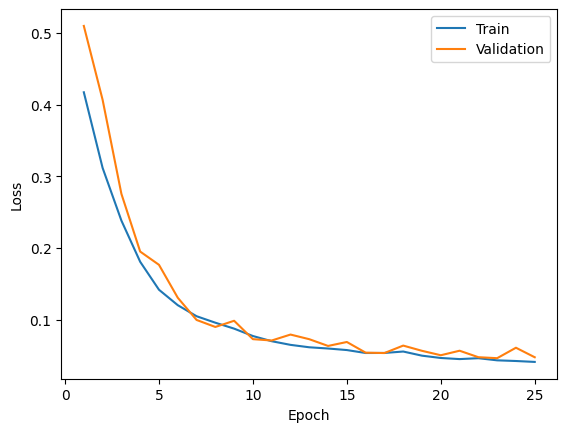

In [ ]:
# Define model under investigation
net = UGNNet(out_channels = 2).to(device)

# Print number of trainable parameters
params = sum(p.numel() for p in net.parameters())
print('Trainable params: ', params)

# Generate dataset 
data = augmented_numpy_dataset(X_total_c,y_total)
print(len(data))

# Randomly split dataset into Training, Validation and Test
split = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator=torch.Generator())

train_loader = DataLoader(split[0], batch_size=16, shuffle=True)
val_loader = DataLoader(split[1], batch_size=16, shuffle=True)
test_loader = DataLoader(split[2], batch_size=16, shuffle=True, drop_last=True)

# Define Loss and Optimizer
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr= 0.0001)

# Train
losses = []
max_epochs = 25

losses = train(net, train_loader, val_loader, test_loader, optim, class_loss, max_epochs)

losses = np.array(losses).T

print(losses.shape)
its = np.linspace(1, len(losses[0]), len(losses[0]))

# Visualize training process
plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])


#### Test set visualization

<Figure size 640x480 with 0 Axes>

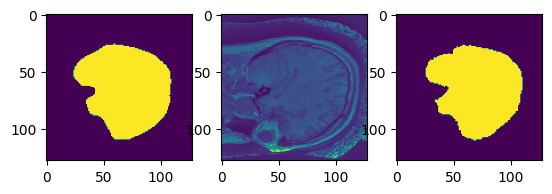

In [ ]:
test_loader = DataLoader(split[2], batch_size=16, drop_last=True)
data, target = next(iter(test_loader))

pred = net(data.to(device))
trans = torch.argmax(pred, dim = 1)

plt.figure()

f, axarr = plt.subplots(1,3) 
axarr[0].imshow(trans[10][:][2].cpu().squeeze())
axarr[1].imshow(data[10][0][:][2].cpu().squeeze())
axarr[2].imshow(1 - target[10][0][:][2].cpu().squeeze())

## Cross Validation

In [ ]:
def cross_validate(model, num_splits=5, batch_size=16, epochs=20):
    """Use (monte carlo) cross validation to evaluate a model on a dataset."""

    # Define Optimizer and Loss
    class_loss = dice_loss()
    optim = torch.optim.Adam(net.parameters(), lr= 0.0001)

    # Define Dataset
    data = augmented_numpy_dataset(X_total_c,y_total)

    # Get the number of graphs and number of pairs
    size = len(data)

    # Arrays to store the train and test accuracies for each fold
    test_accuracies = np.zeros(num_splits)
    
    # Loop over the folds
    for fold in range(num_splits): 

        # Print a header to mark this fold
        print(f"Fold {fold+1}")
        print("============================")
        print()

        split = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator=torch.Generator())

        train_loader = DataLoader(split[0], batch_size=16, shuffle=True)
        val_loader = DataLoader(split[1], batch_size=16, shuffle=True)
        test_loader = DataLoader(split[2], batch_size=16, shuffle=True, drop_last=True)


        # Reset Parameters
        model.reset_parameters()

        # Train with these
        train(net, train_loader, val_loader, test_loader, optim, class_loss, epochs)

        # Record the test and train accuracies for the trained model
        _, test_accuracies[fold] = test(model, test_loader)
    
    # Print the Train and test accuracies for each fold

    
    print(f"{num_splits}-fold validation summary")
    print("============================")
    for fold in range(num_splits):
        print(f"Fold {fold+1}. "
              f"Test: {test_accuracies[fold]:09.5%}")
    params = sum(p.numel() for p in net.parameters())
    print('Trainable params: ', params)


In [ ]:
net = UGNNet(out_channels = 2).to(device)
params = sum(p.numel() for p in net.parameters())
print('Trainable params: ', params)
cross_validate(net, epochs = 25)